Navigate to the minorminer project root

In [1]:
cd ~/Projects/minorminer/

/home/shannie/Projects/minorminer


In [2]:
from collections import Counter
from itertools import product
import math

import networkx as nx
import dwave_networkx as dnx
import matplotlib.pyplot as plt

import minorminer.layout as mml

# Functions for drawing pretty pictures

In [25]:
def draw_layouts(G, layouts, **kwargs):
    rows = math.ceil(len(layouts)/2)
    fig, axs = plt.subplots(rows, 2, figsize=(20,rows*10))
    if rows == 1:
        axs = [axs]
    for i, (name, layout) in enumerate(layouts.items()):
        axis = axs[int(i/2)][i%2]
        nx.draw_networkx(G, pos=layout, ax=axis, **kwargs)
        axis.title.set_text(f"{name}")
    
    if len(layouts) % 2 == 1:
        fig.delaxes(axs[-1][-1])
        
def draw_placement(S, T, placements, **kwargs):
    node_size = kwargs.pop("node_size", 30)
    
    rows = math.ceil(len(placements)/2)
    fig, axs = plt.subplots(rows, 2, figsize=(20,rows*10))
    if rows == 1:
        axs = [axs]
    for i, (name, placement) in enumerate(placements.items()):
        axis = axs[int(i/2)][i%2]
        if T.graph["family"] == "chimera":
            dnx.draw_chimera_embedding(
                T, 
                placement,
                S,
                ax=axis,
                node_size=node_size,
                **kwargs,
            )
        elif T.graph["family"] == "pegasus":
            dnx.draw_pegasus_embedding(
                T, 
                placement,
                S,
                ax=axis,
                node_size=node_size,
                **kwargs,
            )
        chain_lengths = Counter(len(C) for C in placement.values())
        overlaps = len([x for x, val in Counter(x for X in placement.values() for x in X).items() if val > 1])
        axis.title.set_text(f"{name} | {overlaps} overlaps | {dict(chain_lengths)} chains")
    
    if len(placements) % 2 == 1:
        fig.delaxes(axs[-1][-1])

In [4]:
S = nx.random_regular_graph(3, 150)
C = dnx.chimera_graph(13)
P = dnx.pegasus_graph(13)

# Layouts
---
In general, a *layout* of $G$ is defined by the map 
$$f: V(G) \to \mathbb R^d$$

There is a class, `Layout`, to encapsulate this.

# p_norm
---
Let $f$ define a layout of $S$ into $\mathbb R^d$. Minimize the following energy function, $E$, by modifying $f$.
	    $$E = \sum_{u, v \in {G \choose 2}} \Big(d_G \big(u, v \big) - \|f(u) - f(v)\|_p\Big)^2$$

#### Parameters
- p: This changes the $p$-norm.

In [5]:
norms = list(range(1,4)) + [10, float("inf")]

In [6]:
p_norm = {f"{i}-norm": mml.p_norm(S, p=i) for i in norms}

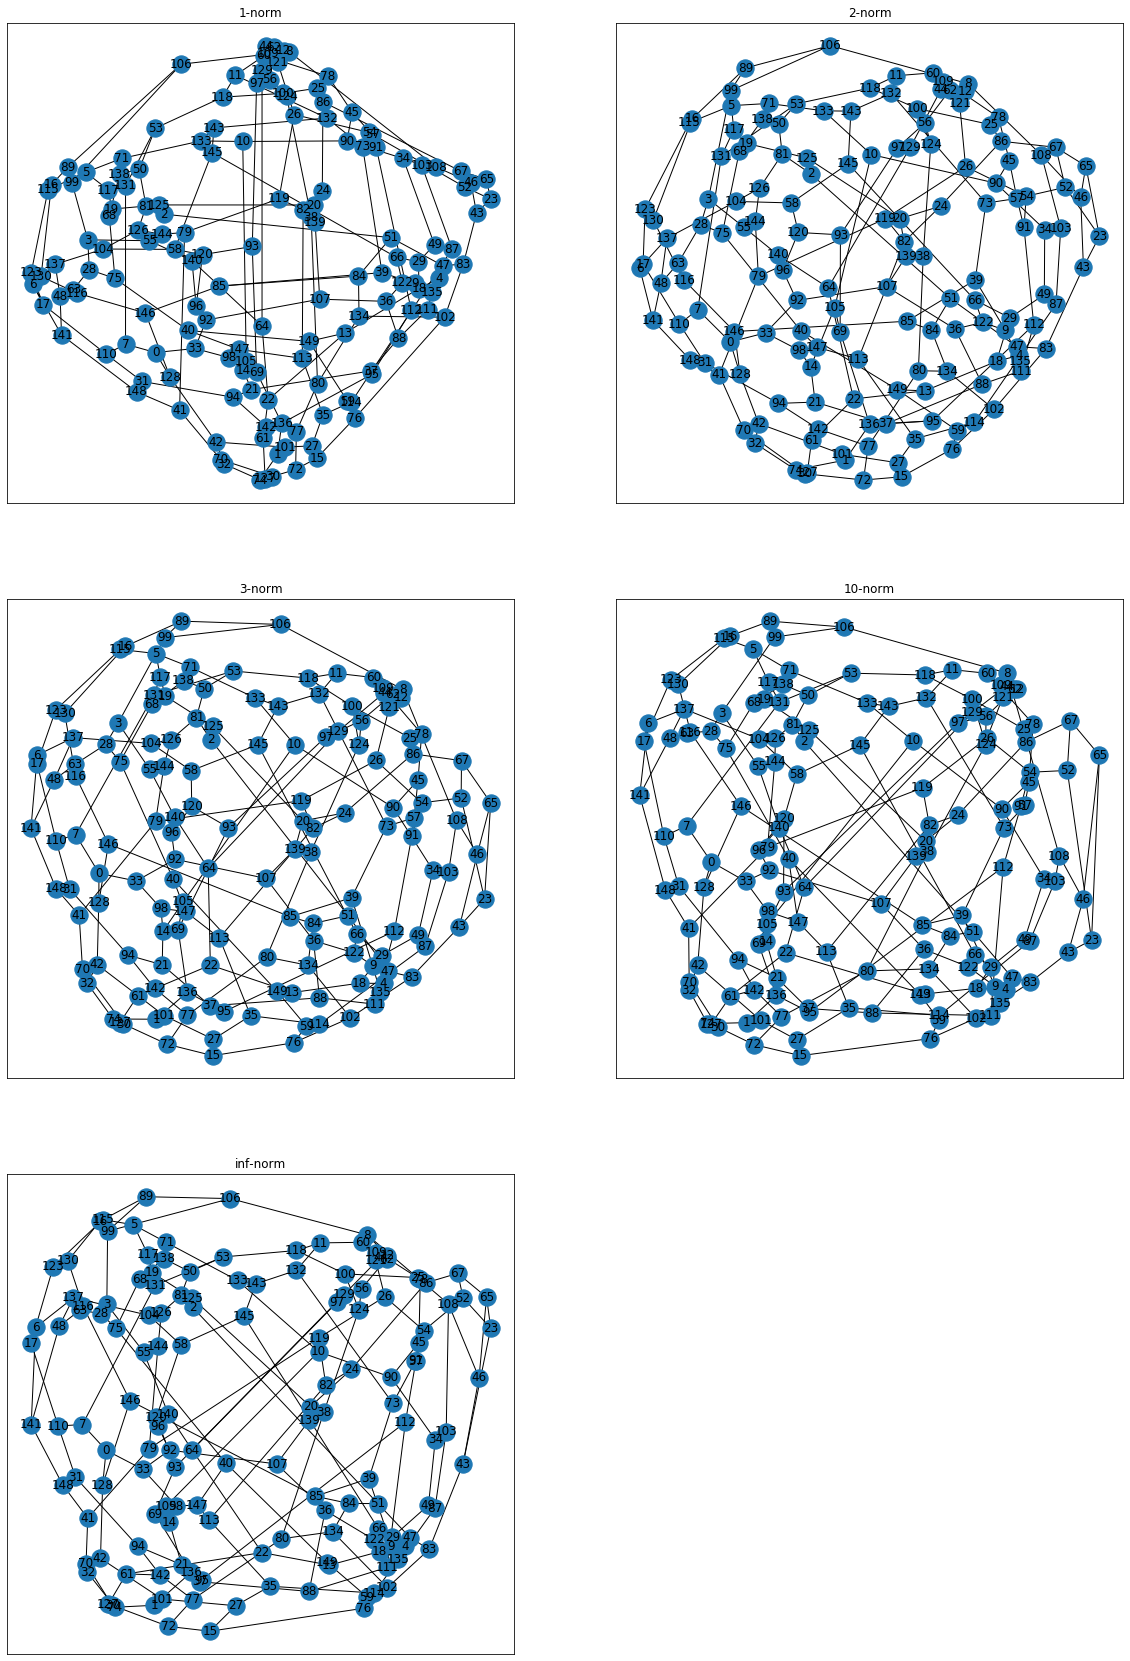

In [7]:
draw_layouts(S, p_norm)

# pca
---
First embeds a graph in an $m$-dimensional space using graph distance for positional vectors. It then projects to a $d$-dimensional space using principal component analysis.

#### Parameters
- m: This changes the interium space to embed into.

In [8]:
M = [2, 50, 100, 150]

In [9]:
pca = {f"pca_{m}": mml.pca(S, m=m) for m in M}

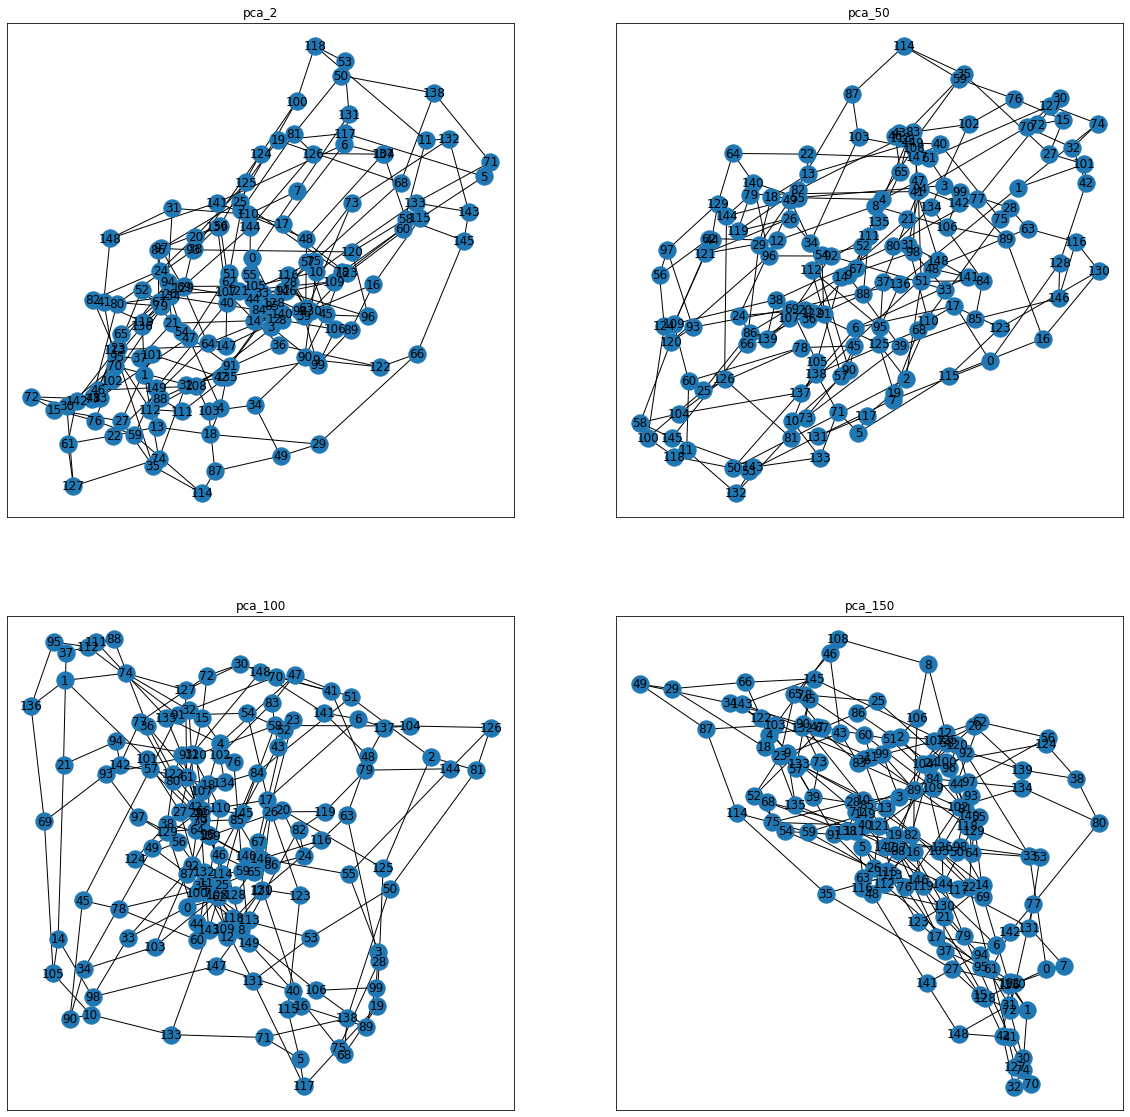

In [10]:
draw_layouts(S, pca)

# Any other layout
---
You can pass in any layout you would like as a dictionary `{vertices: points}` to the `Layout` object.

In [11]:
layouts = {
    "spectral": mml.Layout(S, nx.spectral_layout(S)),
    "spring": mml.Layout(S, nx.spring_layout(S))
}

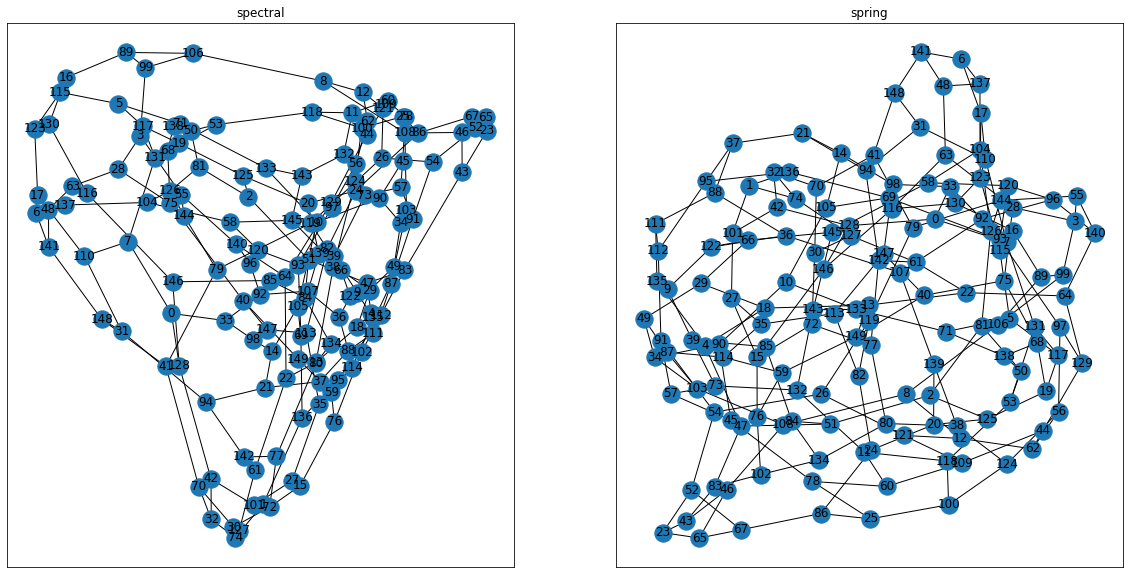

In [12]:
draw_layouts(S, layouts)

## Pick your favorite layout from above before continuing

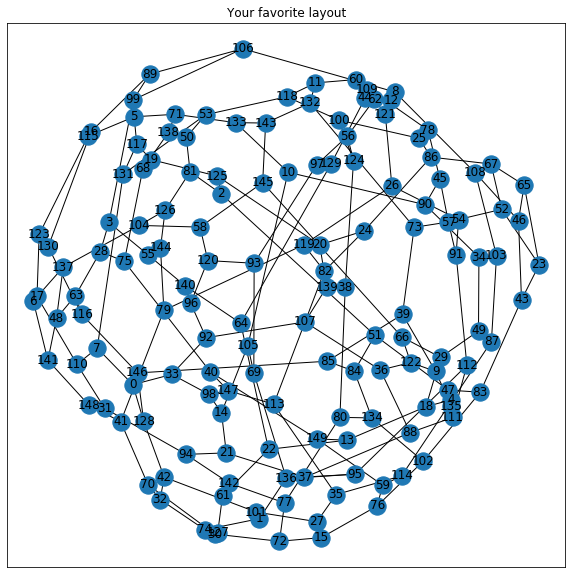

In [13]:
layout = p_norm["2-norm"]
fig, ax = plt.subplots(figsize=(10,10))
nx.draw_networkx(S, pos=layout)
ax.title.set_text("Your favorite layout")

# Placement
---
In general, we say that the map
$$\phi: V(S) \to 2^{V(T)}$$
defines a *placement* of $S$ in $T$ if $\phi(v)$ is connected for all $v \in V(S)$. 

We use layouts from above to define placements. There is a class, `Placement`, that encapsulates this.

#### Parameters
- fill_T: If True, the layout of $S$ is scaled so that it fills the layout of $T$.

# closest
---
Let $f$ and $g$ define respective layouts of $S$ and $T$ into $\mathbb R^d$. With the default parameters, this algorithm maps each vertex $u$ in $S$, to some $v$ in $T$ that minimizes $\|f(u) - g(v)\|_2$.

#### Parameters
- num_neighbors: This is the number of points from $g(T)$ to check before assigning some $u$ in $S$ to $v$ in $T$. Increasing this decreases the overlap.
- subset_sizes: This allows the algorithm to consider larger sets than singletons from $V(T)$. A subset $X \subseteq V(T)$ is represented by the centroid of the points that comprise $X$. I.e. $g$ is extended so that $g: 2^{V(T)} \to \mathbb R^d$ and $g(X) = \texttt{centroid}(\{g(v)| v \in X\})$.

In [14]:
subset_sizes = [(1,1), (1,2), (2,3)]
num_neighbors = [1, 20]

In [15]:
closest = {
    f"{neighbors} neighbors | {subsets} subsets": mml.closest(
        layout, 
        C, 
        subset_size=subsets,
        num_neighbors=neighbors
    ) for subsets, neighbors in product(subset_sizes, num_neighbors)
}

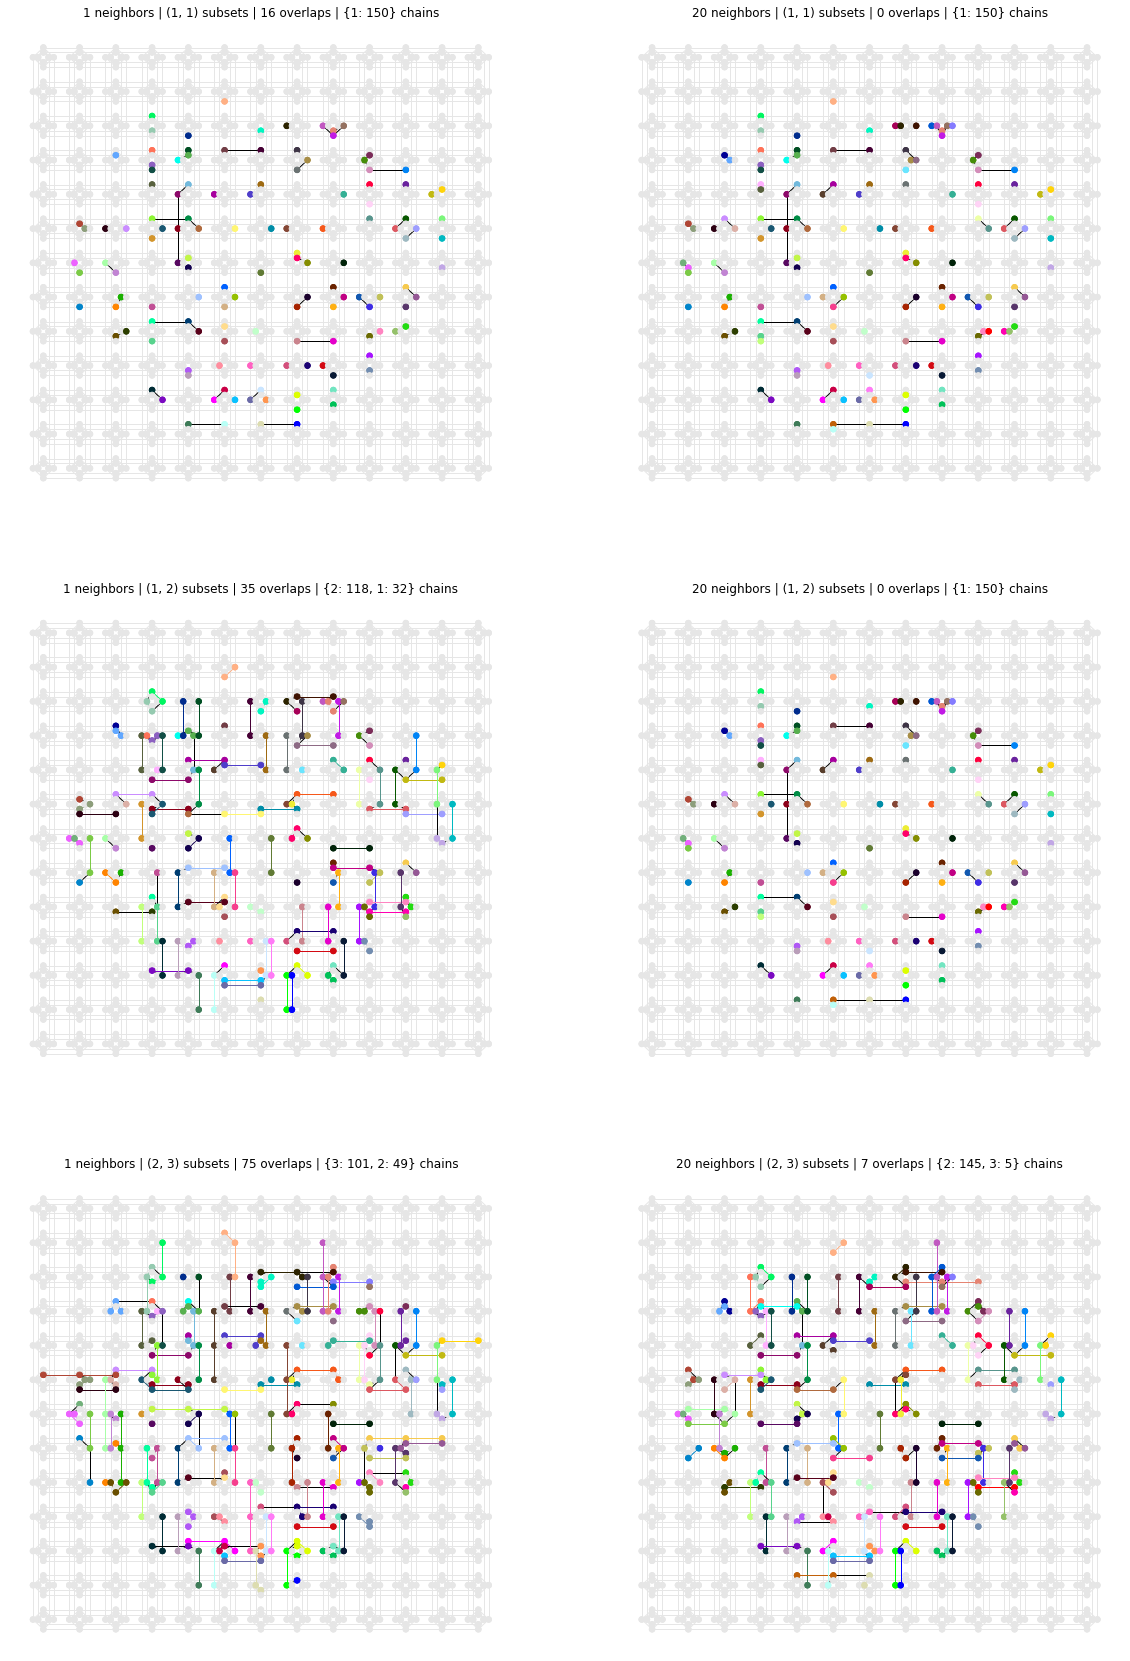

In [28]:
draw_placement(S, C, closest)

# intersection
---
One can think of a Chimera (or Pegasus) as discretizations of the plane where vertical and horizontal columns and rows of qubits form grid lines. An intersection of a pair of these grid lines corresponds to an edge in a unit-cell. We consider the union of these intersection points as a subset of the integer lattice $\mathbb Z^2$. Given a layout, $f$, of $S$ into $\mathbb R^2$, this placement algorithm works in two steps:
- For each each $u$ in $S$, round $f(u)$ to the nearest grid-point $(x, y)$. 
- Set $\phi(u) = \{q, r\}$ where $qr$ is the unit-cell edge in bijection with $(x, y)$. 

In [29]:
intersection = {
    "intersection": mml.intersection(layout, C)
}

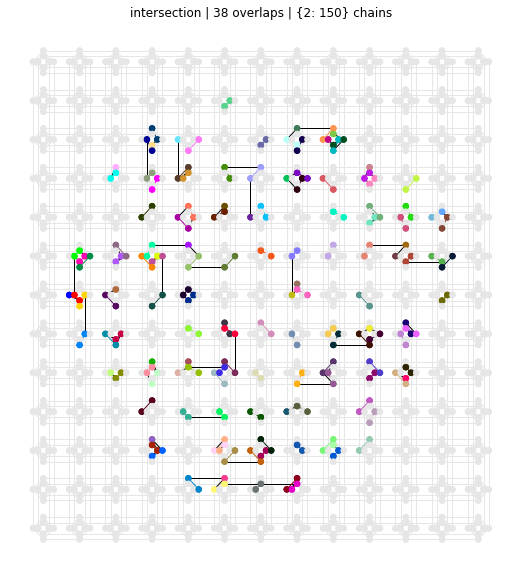

In [31]:
draw_placement(S, C, intersection)

# binning
---
Take the quotient of Chimera (or Pegasus) where each unit-cell (~$K_{4,4}$) is identified. This gives a grid graph. Given a layout, $f$, of $S$ into $\mathbb R^2$, this placement algorithm works in two steps:
- For each each $u$ in $S$, round $f(u)$ to the nearest grid-point $(x, y)$.
- Use some `strategy` to determine the mapping from the vertices of $S$ assigned to the unit-cell in bijection with $(x, y)$ and the qubits contained in the unit-cell.

#### Parameters
- unit_tile_capacity: This is the number of vertices of $S$ that are allowed to be mapped to each unit-cell of $T$.
- strategy: `injective`, `cycle`, or `all`

In [33]:
unit_tile_capacity = list(range(1,5))
strategies = ["injective", "cycle", "all"]

In [46]:
binning = {
    f"{strategy} | {i} unit_tile_capacity": mml.binning(
        layout, C, unit_tile_capacity=i, strategy=strategy)
    for strategy, i in product(strategies, unit_tile_capacity)
}

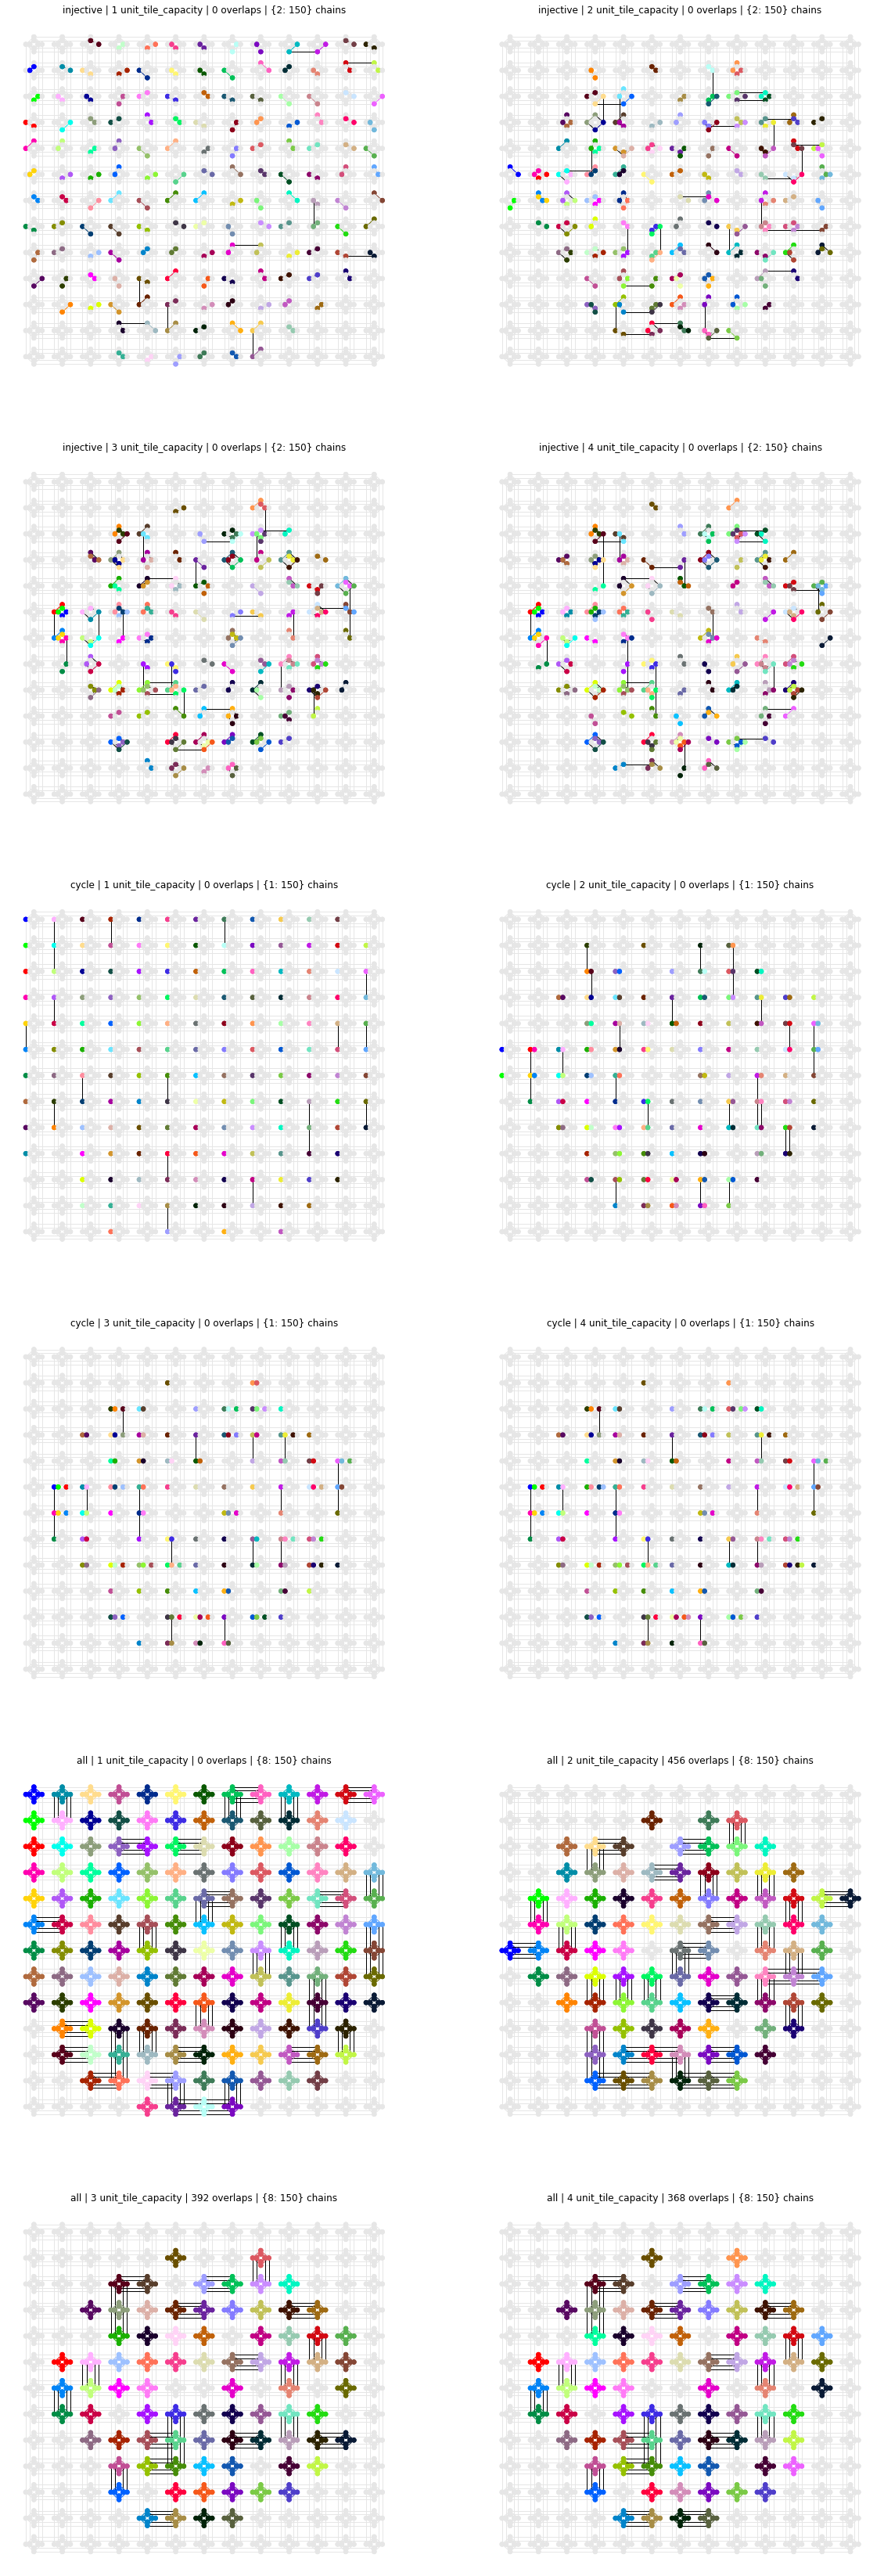

In [47]:
draw_placement(S, C, binning)

## Pick your favorite placement from above before continuing

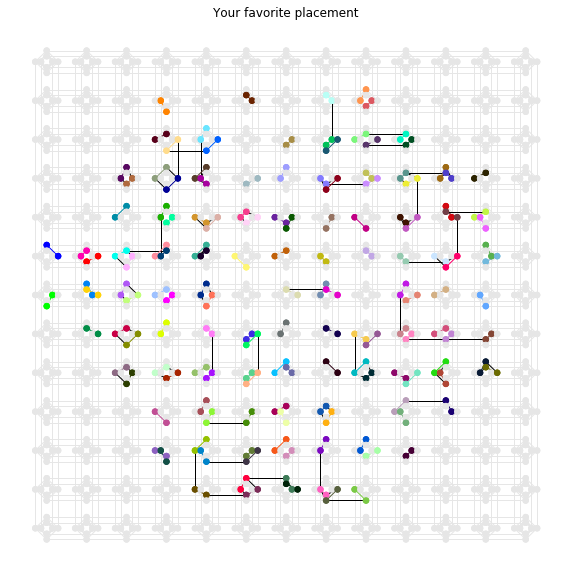

In [52]:
placement = binning["injective | 2 unit_tile_capacity"]
fig, ax = plt.subplots(figsize=(10,10))
dnx.draw_chimera_embedding(C, placement.placement, S, node_size=30)
ax.title.set_text("Your favorite placement")

# Connection
---
In general, we say that a connection, takes a placement of $S$ into $T$ and turns it into an overlap minor.

# crosses
---
Extends the chains of an $S$, $T$ placement along the row-tracks and column-tracks of chimera.

In [50]:
crosses = {"crosses": mml.crosses(placement)}

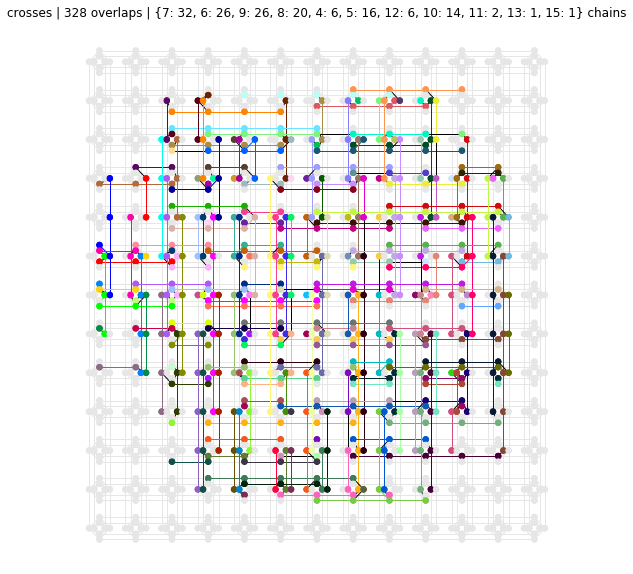

In [51]:
draw_placement(S, C, crosses)